Authors: Bex Dunn, Neil Symington, Claire Krause, Leo Lymburner

### get some modules

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
import matplotlib.pyplot as plt

#dealing with system commands
import sys
import os.path

#modules for datacube
import datacube
from datacube.utils import geometry
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import write_geotiff

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts/'))
from RainfallTools import load_rainfall, calculate_residual_mass_curve

## Choose a time period and location to calculate residual mass curve.
 - Note: please select whole months here, not days, as a month with only two days may negatively affect your mass residual curve

In [7]:
## Choose a q

query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'time':('2010-01', '2013-01')
        }

### load rainfall data

In [44]:
#using the BoM grids to 2013. These are out by 2.5km, be aware.

In [78]:
#rainfall = load_rainfall(query)
dc = datacube.Datacube(app='dc-BOMrainfall')
rainfall = dc.load(product = 'bom_rainfall_grids', **query)

## calculate rainfall mass residual

In [45]:
'''This function calculates the residual mass rainfall curve ##FIXME
:param a: '''
import datacube
import numpy as np
import xarray as xr

## resample rainfall data to month start ##FIXME, daily option

In [79]:
#resample rainfall data to month start
rainfall = rainfall.groupby('time.month').sum(dim='time', keep_attrs='True')

In [80]:
rainfall

<xarray.Dataset>
Dimensions:    (latitude: 2, longitude: 3, month: 12)
Coordinates:
  * latitude   (latitude) float64 -35.27 -35.32
  * longitude  (longitude) float64 149.1 149.1 149.2
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    rainfall   (month, latitude, longitude) float32 114.64193 111.750984 ...
Attributes:
    crs:      EPSG:4326

In [11]:
cumulative_rainfall = rainfall.cumsum(dim='time',keep_attrs=True)

In [19]:
monthly_mean_rainfall = rainfall.groupby('time.month').mean(dim='time', keep_attrs='True')

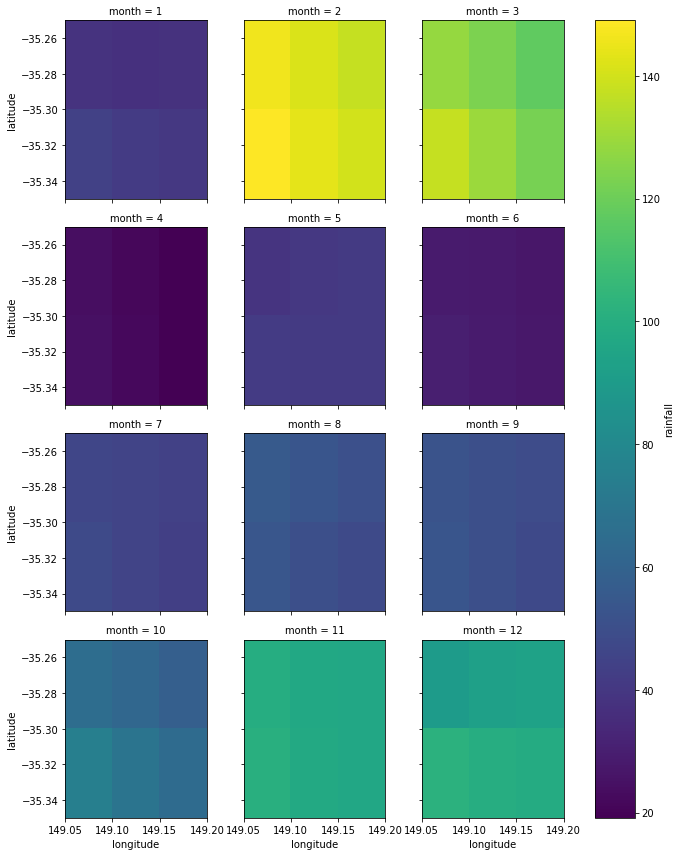

In [28]:
monthly_mean_rainfall.rainfall.plot(col='month',col_wrap=3)

In [46]:
monthly_mean_rainfall

<xarray.Dataset>
Dimensions:    (latitude: 2, longitude: 3, month: 12)
Coordinates:
  * latitude   (latitude) float64 -35.27 -35.32
  * longitude  (longitude) float64 149.1 149.1 149.2
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    rainfall   (month, latitude, longitude) float32 38.213978 37.250324 ...

In [50]:
rainfall = rainfall.groupby('time.month')

In [54]:
monthly_mean_rainfall.broadcast

AttributeError: 'Dataset' object has no attribute 'broadcast'

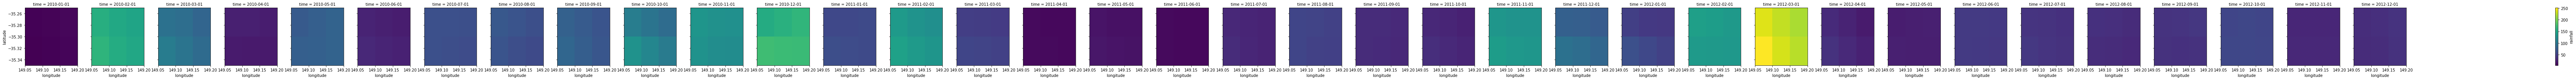

In [15]:
rainfall.rainfall.plot(col='time')

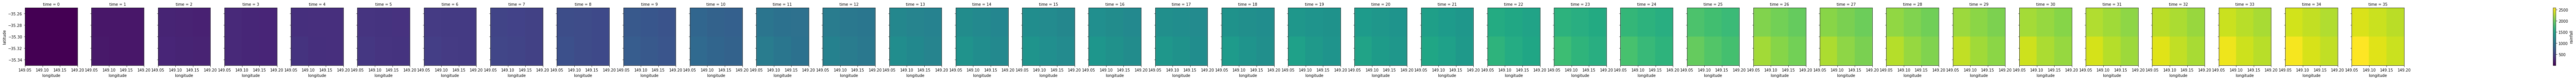

In [16]:
cumulative_rainfall.rainfall.plot(col='time')

In [76]:
monthly_mean_rainfall.rainfall[-1]

<xarray.DataArray 'rainfall' (latitude: 2, longitude: 3)>
array([[ 89.99338 ,  92.651794,  93.80615 ],
       [101.915565, 100.24008 ,  98.77014 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 -35.27 -35.32
  * longitude  (longitude) float64 149.1 149.1 149.2
    month      int64 12

In [73]:
cumulative_rainfall.rainfall[-1]

<xarray.DataArray 'rainfall' (latitude: 2, longitude: 3)>
array([[2438.5889, 2377.4202, 2314.4778],
       [2580.275 , 2456.8137, 2370.8484]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 -35.27 -35.32
  * longitude  (longitude) float64 149.1 149.1 149.2

In [59]:
test =cumulative_rainfall-monthly_mean_rainfall

In [71]:
test.time

<xarray.DataArray 'time' (time: 36)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])
Dimensions without coordinates: time

In [62]:
# The mass residual curve is the difference between the cumulative rainfall data and the cumulative
# rainfall one would get iff the average always occured
mass_res_curve = cum_rf_xr - cum_ave_xr

NameError: name 'cum_ave_xr' is not defined

In [ ]:
def calculate_residual_mass_curve(a):
    '''This function calculates the residual mass rainfall curve
    :param a: '''
    
    #resample rainfall data to month start
    a = a.resample('MS', dim='time', how='sum', keep_attrs=True) 
    # find the number of time steps (ie. years)
    n = len(a.rainfall.time)/12
    
    # First calculate a cumulative rainfall xarray from the rainfall data
    
    arr = a.rainfall.values
    
    cum_rf = np.cumsum(arr, axis = 0)
    
    cum_rf_xr = xr.DataArray(cum_rf, dims = ('time', 'latitude', 'longitude'),
                            coords = [a.time, a.latitude, a.longitude])
    
    # NOw we will calculate a cumulative rainfall assuming average rainfall on a month by month basis
    # Find the average of all months
    ave_months = a.rainfall.groupby('time.month').mean('time').values
   
    # In the case that we are not starting from January we will need to reorder the array
    
    start_month = a.time[0].dt.month.values - 1
    
    ave_month = np.concatenate((ave_months[start_month:,:,:], ave_months[0:start_month,:,:]), axis = 0)

    
    # Tile an array so that we can run a cumulative sum on it
    tiled_ave = np.tile(ave_months, (round(n), 1, 1))
    
    # In the case that we have residual months remove them from the tiled array
    if (n).is_integer() == False:
        month_remainder = int(round((n%1) * 12))

        tiled_ave = tiled_ave[:int(-month_remainder),:,:]
        
    # Generate the cumulative sum of rainfall one would get assuming average rainfall every month
    cum_ave = np.cumsum(tiled_ave, axis = 0)
    
    cum_ave_xr = xr.DataArray(cum_ave, dims = ('time', 'latitude', 'longitude'),
                              coords = [a.time, a.latitude, a.longitude])
    
    # The mass residual curve is the difference between the cumulative rainfall data and the cumulative
    # rainfall one would get iff the average always occured
    mass_res_curve = cum_rf_xr - cum_ave_xr
    
    return mass_res_curve


## calculate metrics based on rainfall
- increasing and decreasing periods
- wet year after dry years
- dry year after wet years
-

## calculate metrics based on residual rainfall
- increasing and decreasing periods
- wet year after dry years
- dry year after wet years


## calculate seasonality
- Koppen climate region (use notebook to follow decision tree - requires climate data)
- Summer dominant, Summer, Uniform, Winter, Winter dominant #
- TROP SOI value
- IOD /SAM indices
"During El Niño, rainfall in eastern Australian is typically below average during winter and spring. A neutral ENSO phase has little effect on Australian climate."Bureau of meteorology http://www.bom.gov.au/climate/enso/  

In [39]:
# Calculate failed wet seasons - calculate total wet season + dry season rainfalls
# (end of wet season rainfalls?)

In [53]:
rainfall.broadcast_to

AttributeError: 'DatasetGroupBy' object has no attribute 'broadcast_to'

In [57]:
help(xr)

Help on package xarray:

NAME
    xarray - # flake8: noqa

PACKAGE CONTENTS
    backends (package)
    coding (package)
    conventions
    convert
    core (package)
    plot (package)
    testing
    tests (package)
    tutorial
    ufuncs
    util (package)
    version

DATA
    absolute_import = _Feature((2, 5, 0, 'alpha', 1), (3, 0, 0, 'alpha', 0...
    division = _Feature((2, 2, 0, 'alpha', 2), (3, 0, 0, 'alpha', 0), 8192...
    print_function = _Feature((2, 6, 0, 'alpha', 2), (3, 0, 0, 'alpha', 0)...

VERSION
    0.10.2

FILE
    /g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/xarray/__init__.py




In [ ]:
rainfall.expand_dims()